# Tutorial 15: Vision Transformers

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial15/Vision_Transformer.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial15/Vision_Transformer.ipynb)   
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial15)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1BmisSPs5BXQKpolyHp5X4klSAhpDx479?usp=sharing)   
**Recordings:** 
[![YouTube - Part 1](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%201&color=red)](https://youtu.be/4UyBxlJChfc)   
**JAX+Flax version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial15/Vision_Transformer.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** Interested in JAX? Check out our [JAX+Flax version](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial15/Vision_Transformer.html) of this tutorial!
    
</div>

In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib

# matplotlib.rcParams['lines.linewidth'] = 2.0
# import seaborn as sns
# sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
# %load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial15"

# Setting the seed
# pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_4520/3796580224.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: cuda:0


We provide a pre-trained Vision Transformer which we download in the next cell. However, Vision Transformers can be relatively quickly trained on CIFAR10 with an overall training time of less than an hour on an NVIDIA TitanRTX. Feel free to experiment with training your own Transformer once you went through the whole notebook.

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/"
# Files to download
pretrained_files = ["tutorial15/ViT.ckpt", "tutorial15/tensorboards/ViT/events.out.tfevents.ViT",
                    "tutorial5/tensorboards/ResNet/events.out.tfevents.resnet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name.split("/",1)[1])
    if "/" in file_name.split("/",1)[1]:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

We load the CIFAR10 dataset below. We use the same setup of the datasets and data augmentations as for the CNNs in Tutorial 5 to keep a fair comparison. The constants in the `transforms.Normalize` correspond to the values that scale and shift the data to a zero mean and standard deviation of one. 

In [3]:
which_db = 'mnist'

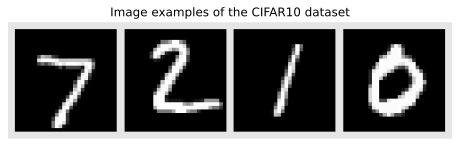

In [4]:
if which_db == 'mnist':

  DOWNLOAD_PATH = './data/mnist'
  BATCH_SIZE_TRAIN = 200
  BATCH_SIZE_TEST = 1000

  transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))])

  train_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=True, download=True,
                                        transform=transform_mnist)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

  test_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=False, download=True,
                                        transform=transform_mnist)

  # rename to val !!!!! remmber
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)


  # Visualize some examples
  NUM_IMAGES = 4
  mnist_images = torch.stack([test_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
  img_grid = torchvision.utils.make_grid(mnist_images, nrow=4, normalize=True, pad_value=0.9)
  img_grid = img_grid.permute(1, 2, 0)

  plt.figure(figsize=(8,8))
  plt.title("Image examples of the CIFAR10 dataset")
  plt.imshow(img_grid)
  plt.axis('off')
  plt.show()
  plt.close()


In [5]:
if which_db == 'fashionmnist':
  DOWNLOAD_PATH = './data/fashionmnist'
  BATCH_SIZE_TRAIN = 200
  BATCH_SIZE_TEST = 1000

  transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))])

  train_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=True, download=True,
                                        transform=transform_mnist)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

  test_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=False, download=True,
                                        transform=transform_mnist)

  # rename to val !!!!! remmber
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)


  # Visualize some examples
  NUM_IMAGES = 4
  mnist_images = torch.stack([test_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
  img_grid = torchvision.utils.make_grid(mnist_images, nrow=4, normalize=True, pad_value=0.9)
  img_grid = img_grid.permute(1, 2, 0)

  plt.figure(figsize=(8,8))
  plt.title("Image examples of the CIFAR10 dataset")
  plt.imshow(img_grid)
  plt.axis('off')
  plt.show()
  plt.close()


In [6]:
def apply_norm(wei, ln=None, C=None):
        if  norm_type in ['layernorm', 'layernorm2D', 'no-sm-layernorm']:
            wei = ln(wei)

        elif norm_type in ['std', 'no-sm-std']: # zero mean each row and divide by variance
            std = wei.std(-1, keepdim=True)
            wei = (wei - wei.mean(-1,keepdim=True)) / std

        elif norm_type == 'L2': # unit length 
            wei = wei/((wei**2).sum(axis=-1, keepdim=True).sqrt())

        elif norm_type == 'sqrt':
            wei *= C

        elif norm_type == 'sqrt+std':    
            wei *= C
            std = 1 if wei.size(1)==1 else wei.std(-1, keepdim=True)
            wei = (wei - wei.mean(-1,keepdim=True)) / std

        else:
          raise Exception('undefined norm type')

        return wei

In [7]:
!pip install einops

In [8]:
import torch
import torch.nn.functional as F

from torch import nn
from einops import rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

In [1]:
class Attention(nn.Module):
    def __init__(self, dim, heads=8):              
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)
        
        # self.ln = nn.LayerNorm(sequence_length).to(device) if norm_type in ['layernorm', 'no-sm-layernorm'] else None        

        # layer norm 2D
        if norm_type == 'layernorm':
          self.ln = nn.LayerNorm(sequence_length).to(device)
          
        elif norm_type == 'layernorm2D':
          self.ln = nn.LayerNorm(sequence_length,sequence_length).to(device)

        else:
          self.ln = None
        

        # self.ln = nn.LayerNorm(sequence_length,sequence_length).to(device) if norm_type in ['layernorm', 'no-sm-layernorm'] else None        


    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)
        dots = torch.einsum('bhid,bhjd->bhij', q, k) 

        dots = apply_norm(dots, self.ln, self.scale)

        # attn = dots.softmax(dim=-1)
        
        if norm_type not in ['no-sm-std', 'no-sm-layernorm']:
            attn = dots.softmax(dim=-1)
        else:
            attn = dots
        

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out




class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):              
        super().__init__()

        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

                

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x


NameError: name 'nn' is not defined

In [10]:
class ViT(pl.LightningModule):
  
    def __init__(self, model_kwargs, lr):              
        super().__init__()

        image_size = model_kwargs['image_size']
        patch_size = model_kwargs['patch_size']
        num_classes = model_kwargs['num_classes']
        dim = model_kwargs['dim']
        depth=model_kwargs['depth']
        heads=model_kwargs['heads']
        mlp_dim=model_kwargs['mlp_dim']
        channels=model_kwargs['channels']

        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))


        self.model = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )


        self.save_hyperparameters()
        # self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]



    def forward(self, img, mask=None):
        j = self.patch_size
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = j, p2 = j)
        
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding

        x = self.model(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)        




    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]   
    
    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.forward(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        
        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)


        if mode=="train":
            results[(norm_type, run_no)]['train_loss_history'].append(loss.item())
            results[(norm_type, run_no)]['time_spent'].append(time.time() - start_time)

        elif mode=="val":
            results[(norm_type, run_no)]['test_loss_history'].append(loss.item())       
            results[(norm_type, run_no)]['test_time_spent'].append(time.time() - start_time)   


        return loss


    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")


In [11]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=num_epochs,
                        #  val_check_interval=20,
                         val_check_interval=0.25,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")])
    # trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    # trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    # pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    # if os.path.isfile(pretrained_filename):
    #     print(f"Found pretrained model at {pretrained_filename}, loading...")
    #     model = ViT.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    # else:
    # pl.seed_everything(42) # To be reproducable
    model = ViT(**kwargs)
    trainer.fit(model, train_loader, test_loader)
    model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    # val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"]} #, "test": test_result[0]["test_acc"]}

    return model, result

In [12]:
import time
import os.path
import json
import pickle

# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
# with open(f'drive/MyDrive/KV_Transformer_Res/128_1_2_psize_7_mnist.pkl', 'rb') as f:
#   results = pickle.load(f)


In [14]:
# results.keys()
# p_size = 7
# d_dim = 128
# d_depth = 1
# h_heads = 2


# num_runs = 4

In [15]:
# len(results[('no-sm-std', 1)]['test_time_spent'])

In [16]:
# !rm drive/MyDrive/KV_Transformer_Res -rf
!rm ../saved_models/tutorial15/ViT.ckpt
# ViT.__dict__


In [24]:
num_classes = 10
num_channels = 1
image_size = 28





p_size = 4
d_dim = 256
d_depth = 6
h_heads = 4

num_epochs = 10
num_runs = 3

lr = 1e-3



sequence_length = (image_size // p_size)**2 + 1

In [ ]:
results = {}


mlp_dim = d_dim

# for norm_type in ['std', 'L2', 'sqrt', 'layernorm']:


for norm_type in ['std', 'sqrt', 'layernorm']:

    for run_no in range(num_runs):

      print(f'{which_db}---------- norm type: {norm_type}, run number: {run_no} ------------------------------')

      results[(norm_type, run_no)] = {}
      results[(norm_type, run_no)]['time_spent'] = []  
      results[(norm_type, run_no)]['train_loss_history'] = []  
      results[(norm_type, run_no)]['test_loss_history'] = []  
      results[(norm_type, run_no)]['test_time_spent'] = []  

      start_time = time.time()



      model, results_x = train_model(model_kwargs={
                              'image_size': image_size, 
                              'patch_size': p_size, 
                              'num_classes':num_classes, 
                              'channels':num_channels,                
                              'dim':d_dim, 
                              'depth':d_depth, 
                              'heads':h_heads, 
                              'mlp_dim':d_dim,
                                  },
                                  lr=1e-3)
      
      print("ViT results", results_x)

      results[(norm_type, run_no)]['test_acc'] = results_x['test']


      if not os.path.exists(f'./results'):
        os.mkdir(f'./results')


      with open(f'./results/{d_dim}_{d_depth}_{h_heads}_{num_epochs}_{lr}_{sequence_length}_{which_db}.pkl', 'wb') as f:
        pickle.dump(results, f)


      # with open(f'drive/MyDrive/KV_Transformer_Res/{d_dim}_{d_depth}_{h_heads}_psize_{p_size}_{which_db}.pkl', 'wb') as f:
      #   pickle.dump(results, f)



In [30]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [31]:
%matplotlib inline

In [32]:
# compute the averages 
results_avg = {}

for key, _ in results.keys():
    results_avg[key] = {}

for key in results.keys():
       for x,y in results[key].items():
          if x in results_avg[key[0]]:
            results_avg[key[0]][x] += np.array(y)
          else: 
            results_avg[key[0]][x] = np.array(y)
    

# compute the avg
for key,val in results_avg.items():
      for x, y in val.items():
          y = np.array(y)
          results_avg[key][x] = y / num_runs


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/KV_Transformer_Res/128_4_4_10_0.001_50_mnist_avg.png'

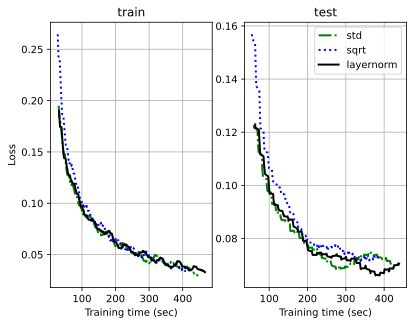

In [33]:
smooth_factor_train = 200
smooth_factor_val = 50



fig, axs = plt.subplots(1,2) #, sharex=True, sharey=True)

colors = ['g-.', 'b:', 'k']

idx = 0
for key in results_avg.keys():
      t_time = results_avg[key]['time_spent'] 
      box_size = smooth_factor_train 
      tt = results_avg[key]['train_loss_history']
      ss = smooth(tt,box_size)[box_size:-box_size]

      axs[0].plot(t_time[box_size:-box_size], ss, colors[idx], lw=2)
      axs[0].grid('on')

      axs[0].set(title='train', xlabel='Training time (sec)', ylabel='Loss')


      idx += 1



idx = 0
for key in results_avg.keys():
      t_time = results_avg[key]['test_time_spent'] 
      box_size = smooth_factor_val 
      tt = results_avg[key]['test_loss_history']
      ss = smooth(tt,box_size)[box_size:-box_size]

      axs[1].plot(t_time[box_size:-box_size], ss, colors[idx], lw=2)
      axs[1].grid('on')

      axs[1].set(title='test', xlabel='Training time (sec)')

      axs[1].legend(list(results_avg.keys())) 

      idx += 1




fig.savefig(f'drive/MyDrive/KV_Transformer_Res/{d_dim}_{d_depth}_{h_heads}_{num_epochs}_{lr}_{sequence_length}_{which_db}_avg.png', dpi=150, format="png")


In [ ]:
# accs

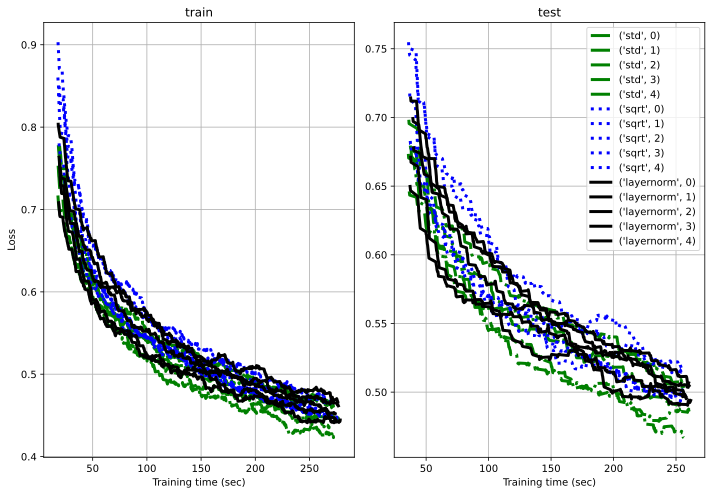

In [58]:
fig, axs = plt.subplots(1,2, figsize=(10,7)) #, sharex=True, sharey=True)


idx = 0
for key, c in results.keys():
      t_time = results[(key, c)]['time_spent'] 
      box_size = smooth_factor_train 
      tt = results[(key, c)]['train_loss_history']
      ss = smooth(tt,box_size)[box_size:-box_size]

      axs[0].plot(t_time[box_size:-box_size], ss, colors[idx//num_runs], lw=3)
      axs[0].grid('on')

      axs[0].set(title='train', xlabel='Training time (sec)', ylabel='Loss')

      idx += 1



idx = 0
for key, c in results.keys():
      t_time = results[(key, c)]['test_time_spent'] 
      box_size = smooth_factor_val 
      tt = results[(key, c)]['test_loss_history']
      ss = smooth(tt,box_size)[box_size:-box_size]      

      axs[1].plot(t_time[box_size:-box_size], ss, colors[idx//num_runs], lw=3)
      axs[1].grid('on')

      axs[1].set(title='test', xlabel='Training time (sec)')
      axs[1].legend(list(results.keys())) 

      idx += 1


fig.tight_layout()
plt.show()


fig.savefig(f'drive/MyDrive/KV_Transformer_Res/{d_dim}_{d_depth}_{h_heads}_{num_epochs}_{lr}_{sequence_length}_{which_db}_all.png', dpi=150, format="png")

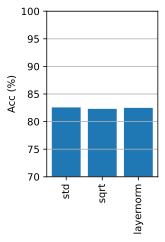

In [56]:
fig = plt.figure(figsize=(2,3))

accs = []
for (key,val), c in zip(results_avg.items(), colors):
    accs.append(results_avg[key]['test_acc']*100)

bars = plt.bar(np.arange(len(accs)), accs)
plt.xticks(np.arange(len(accs)), list(results_avg.keys()), rotation=90)

# for bar,c in zip(bars, colors):
#   bar.set_color(c)

fig.gca().yaxis.grid(True, zorder=0,)
plt.ylabel('Acc (%)')
plt.ylim(70,100)
plt.show()



fig.savefig(f'drive/MyDrive/KV_Transformer_Res/{d_dim}_{d_depth}_{h_heads}_{num_epochs}_{lr}_{sequence_length}_{which_db}_acc.png', dpi=150, format="png")